# Determining the cost of cars

A used car dealership is developing an app to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment, and prices of vehicles. We need to build a model to determine the cost.

The customer is important:

- the quality of the prediction;
- prediction speed;
- studying time.

## Data exploration and preprocessing

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import random
import time
import warnings
warnings.filterwarnings('ignore')

### Data exploration

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()
display(pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,0
NotRepaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
LastSeen,0.000000
PostalCode,0.000000
NumberOfPictures,0.000000
DateCreated,0.000000
Brand,0.000000


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

There are gaps in the data  
</div>

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

There are strange values: zeros and high values
</div>

In [6]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for column in columns:
    display(data.sort_values(by = column)[column].unique())

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

array(['auto', 'manual', nan], dtype=object)

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

array(['no', 'yes', nan], dtype=object)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Done.  
    
Before us is data on the cost of cars with various features:
    
- <code>DateCrawled</code> — date of downloading the questionnaire from the database
- <code>VehicleType</code> — car body type
- <code>RegistrationYear</code> — year of vehicle registration
- <code>Gearbox</code> — gearbox type
- <code>Power</code> - power (hp)
- <code>Model</code> — car model
- <code>Kilometer</code> — mileage (km)
- <code>RegistrationMonth</code> — car registration month
- <code>FuelType</code> — fuel type
- <code>Brand</code> — car brand
- <code>NotRepaired</code> — was the car under repair or not
- <code>DateCreated</code> — date of creation of the questionnaire
- <code>NumberOfPictures</code> - number of car photos
- <code>PostalCode</code> — postal code of the owner of the profile (user)
- <code>LastSeen</code> — date of last user activity
- <code>Price</code> — price (EUR)

    
We need to find the optimal model to predict the cost of cars according to the following parameters: prediction quality, training time, and prediction time.
    
To do this, we will take the following steps:
- Data preprocessing
- Preparing data for training models
- Model training
- Analysis and search for the corresponding model
    

    
<hr>
<b> Data preprocessing plan</b>
    
The data contains columns that do not affect the real assessment of the car:
    
<code>DateCrawled</code>, <code>DateCreated</code>, <code>NumberOfPictures</code>, <code>PostalCode</code>, <code>LastSeen</code>
    
We will remove them. Only one field can be controversial here: Zip code. Depending on the place of sale, the price of cars is different. But in this case, it is better to consider not indices but cities or regions. Index - too precise specification of the place. In this case, you can take a dataset from open sources and find a specific city/area of car sales for each index. With this data, predictions of the possible cost of a car will not only be tuned to a specific model and parameters of the vehicle but also take into account the user's location.

<hr>
    
The data has strange column values:
    
- <code>Price</code> - There are zero values, we will delete them
- <code>RegistrationYear</code> - Data from the future and the Middle Ages exists. Too old cars are difficult to evaluate due to the lack of information on their rarity and collection value. We restrict ourselves to data between 1960-2021.
- <code>Power</code> - there are cars without an engine and with a rocket engine. We will remove the zero ones and look at the overpriced ones on the box with a mustache
- <code>RegistrationMonth</code> - there is a zero month; we will replace it with a random one
    
<hr>
There are gaps in the data:
- <code>NotRepaired</code> 20.08% - replace these gaps with the value <code>unknown</code> since we will not be able to predict whether the car was repaired or not.
    
    
With the remaining passes:
- <code>VehicleType</code> 10.58%
- <code>FuelType</code> 9.28%
- <code>Gearbox</code> 5.6%
- <code>Model</code> 5.56%
    
Let's do it in two ways:
    
1. Let's try to insert missing values based on the information that we were provided
2. Delete rows where values were missing
And in the end, when analyzing our model, we will decide which data preprocessing method is best.
    
    
<hr>
We also slightly transform the names of models and brands. There are underscores, and we will not check all names for typos because of these characters.
    
And after all the actions, we will remove complete duplicates from the data.
    
It looks like a plan
</div>

### Data preprocessing

In [7]:
# Removing unnecessary columns
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)


In [8]:
# Remember the original number of lines
data_rows_begin = data.shape[0]

# We remove zero prices and strange years of registration
data = data[data['Price'] != 0]
data = data[(data['RegistrationYear'] >= 1960) & (data['RegistrationYear'] <= 2021)]

# Replace unknown repair value with 'unknown'
data.loc[:,'NotRepaired'] = data['NotRepaired'].fillna('unknown')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

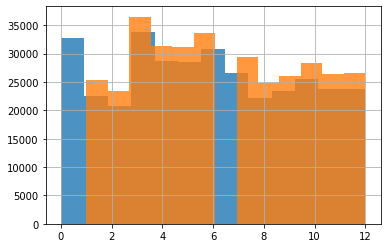

In [9]:
# Replace the zero month with a random one
display(sorted(data['RegistrationMonth'].unique()))

def random_digit(row):
    month = row['RegistrationMonth']
    if month == 0:
        return random.randint(1, 12)
    else:
        return month
data['RegistrationMonth'].hist(alpha=0.8, bins = 13);
data['RegistrationMonth'] = data.apply(random_digit, axis=1)
data['RegistrationMonth'].hist(alpha=0.8, bins = 13)

display(sorted(data['RegistrationMonth'].unique()))

In [10]:
# Let's make a version of the dataset in which all missing values will simply be deleted
df = data.dropna().reset_index(drop=True)

In [11]:
pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
VehicleType,9.780000
FuelType,8.530000
Model,5.060000
Gearbox,5.000000
NotRepaired,0.000000
Brand,0.000000
RegistrationMonth,0.000000
Kilometer,0.000000
Power,0.000000
RegistrationYear,0.000000


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Intermediate check. There were fewer gaps. Let's look at unique values
    
</div>

In [12]:
columns = ['VehicleType', 'FuelType', 'Model', 'Gearbox', 'NotRepaired']
for column in columns:
    display(data.sort_values(by = column)[column].unique())

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

array(['auto', 'manual', nan], dtype=object)

array(['no', 'unknown', 'yes'], dtype=object)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

What will we do with the power of cars?
    
The plan is this:
1. Let's make a dataset <code>clean_data</code>; in it we will create unique names for each line in which there is no gap
1. Let's create a dictionary (since there can be several values for one data set)
1. Sort by popularity
1. Add the most common option to the dictionary.
1. Look at the mustachioed box to figure out which abnormal values we need to change.
1. Anomalous values are replaced with NaN, and using the dictionary, we correct them for the most popular
    
If everything works out, we use the same idea for missing values.
    
</div>

In [13]:
# Remove underscores from model and brand names
data.loc[:,'Model'] = data['Model'].replace(r'[_]','', regex=True)
data.loc[:,'Brand'] = data['Brand'].replace(r'[_]','', regex=True)

# Let's make a clean date and create a unique name column in it
clean_data = data[['Brand','Model','VehicleType','Gearbox','Power','FuelType']].copy().dropna()
clean_data['unique_name'] = clean_data['Brand']+clean_data['Model']+clean_data['VehicleType']+clean_data['Gearbox']+clean_data['FuelType']

# We will also do this in the original datasets
data['unique_name'] = data['Brand']+data['Model']+data['VehicleType']+data['Gearbox']+data['FuelType']
df['unique_name'] = df['Brand']+df['Model']+df['VehicleType']+df['Gearbox']+df['FuelType']
display(clean_data.head())

power_dict = clean_data.groupby('unique_name')['Power'].agg(lambda x:x.value_counts(ascending=False).index[0])
power_dict = dict(power_dict[power_dict > 0])


,Brand,Model,VehicleType,Gearbox,Power,FuelType,unique_name
2,jeep,grand,suv,auto,163,gasoline,jeepgrandsuvautogasoline
3,volkswagen,golf,small,manual,75,petrol,volkswagengolfsmallmanualpetrol
4,skoda,fabia,small,manual,69,gasoline,skodafabiasmallmanualgasoline
5,bmw,3er,sedan,manual,102,petrol,bmw3ersedanmanualpetrol
6,peugeot,2reihe,convertible,manual,109,petrol,peugeot2reiheconvertiblemanualpetrol


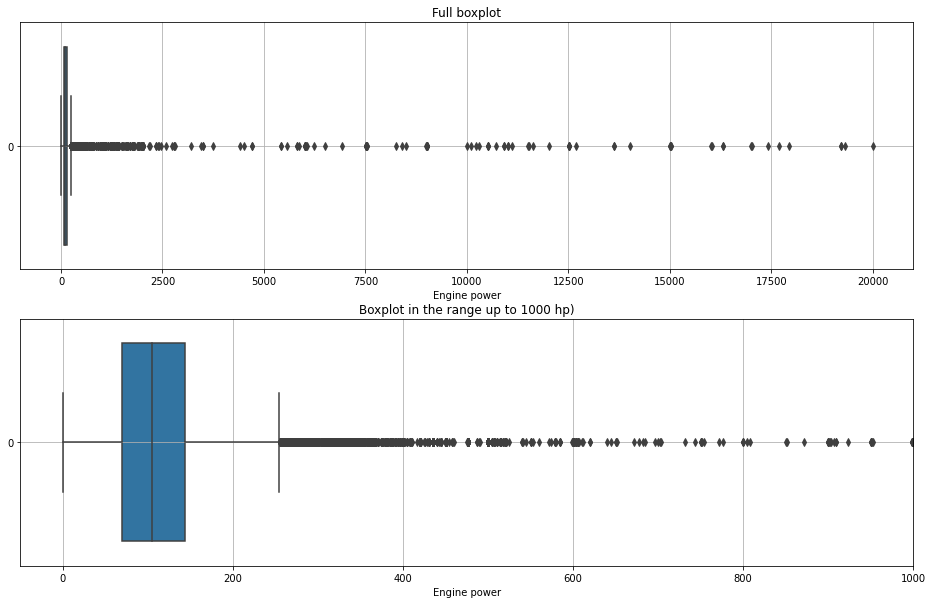

In [14]:
f, (ax1, ax2) = plt.subplots(2,1)
sns.boxplot(data=data['Power'], orient='horizontal', ax=ax1)
ax1.set(xlabel='Engine power', title='Full boxplot')
ax1.grid(True)
sns.boxplot(data=data['Power'], orient='horizontal', ax=ax2)
ax2.set(xlabel='Engine power', xlim=(-50,1000),\
        title='Boxplot in the range up to 1000 hp)')
ax2.grid(True)
f.set_figwidth(16)
f.set_figheight(10)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
The main power values ​​are in the range up to 500-600 hp. Let's leave them
</div>

In [15]:
max_power = 550
data.loc[data['Power']>max_power,'Power'] = np.nan
data.loc[:,'Power'] = data['Power'].fillna(data['unique_name'].map(power_dict))
data = data[data['Power']<=max_power].reset_index(drop=True)
data['Power'] = data['Power'].astype(int)

df.loc[data['Power']>max_power,'Power'] = np.nan
df.loc[:,'Power'] = df['Power'].fillna(df['unique_name'].map(power_dict))
df = df[df['Power']<=max_power].reset_index(drop=True)
df['Power'] = df['Power'].astype(int)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
Let's make a function based on what we just did above, but now in order to replace real gaps, and not correct anomalies in the data.
    
    
</div>

In [16]:
def handling_passes(recovery_column):
    
    # Selecting the required columns, except for what we fix 
    columns = ['Brand','Model','VehicleType','Gearbox','Power','FuelType']
    columns.remove(recovery_column)
    
    # Creating a dictionary key
    clean_data['unique_name'] = ''
    data['unique_name'] = ''
    for column in columns:
        clean_data['unique_name'] += clean_data[column].astype(str)
        data['unique_name'] += data[column].astype(str)
        
    # Apply lambda function
    dictionary = dict(clean_data.groupby('unique_name')[recovery_column].agg(lambda x:x.value_counts(ascending=False).index[0]))
    # We return what we found in the dictionary
    return data[recovery_column].fillna(data['unique_name'].map(dictionary))

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
Let's keep in memory how many passes there were before    
    
</div>

In [17]:
vehicle_type = data['VehicleType'].isna().sum()
gearbox = data['Gearbox'].isna().sum()
model = data['Model'].isna().sum()
fuel_type = data['FuelType'].isna().sum()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
Let's apply the function only to <code>data</code>. In the <code>df</code> dataset, we will remove these gaps. This is exactly the difference between them.
    
</div>

In [18]:
%%time
columns = ['VehicleType','Gearbox','Model','FuelType']
for column in columns:
    data.loc[:,column] = handling_passes(column)
    
data = data.drop(columns='unique_name')
df = df.drop(columns='unique_name')

Wall time: 34.5 s


In [19]:
pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].head().style.background_gradient('coolwarm')

,0
VehicleType,5.780000
FuelType,5.650000
Model,3.140000
Gearbox,3.110000
NotRepaired,0.000000


In [20]:
print('Restored values:')
print(f'VehicleType: {vehicle_type - data["VehicleType"].isna().sum()}')
print(f'Gearbox: {gearbox - data["Gearbox"].isna().sum()}')
print(f'Model: {model - data["Model"].isna().sum()}')
print(f'FuelType: {fuel_type - data["FuelType"].isna().sum()}')

Restored values:
VehicleType: 13684
Gearbox: 6477
Model: 6538
FuelType: 9846


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
It worked out well. We inserted values in almost every second case of omission.

If there were some other unique value in the data, for example, the region, then there would be fewer complete duplicates.
    
PS. I tried not to remove duplicates; the model gives RMSE lower, but just a little bit. The speed of learning and prediction increases quite noticeably. Therefore, we will eventually remove duplicates.
    
</div>

In [21]:
print(f'The size of the dataset with processed gaps before removing full duplicates - {data.shape}.\
\nOnly {round((data_rows_begin-data.shape[0])/data_rows_begin*100,2)}% percent of rows removed.\n')

# Датасет с обработкой пропусков
print('Number of duplicates in the dataset with gap processing:', data[data.duplicated()]['Price'].count())

data.drop_duplicates(inplace=True)

print(f'Dataset size after removing full duplicates {data.shape}.\
\n{round((data_rows_begin-data.shape[0])/data_rows_begin*100,2)}% of rows removed.\n')

# Датасет с удалением пропусков
print('Number of duplicates in the dataset with gaps removed:', df[df.duplicated()]['Price'].count())

df.drop_duplicates(inplace=True)

print(f'Dataset size after removing full duplicates {df.shape}.\
\nAs many as {round((data_rows_begin-df.shape[0])/data_rows_begin*100,2)}% of rows have been removed.')

#на всякий случай
data = data.dropna().reset_index(drop=True)
df = df.dropna().reset_index(drop=True)

The size of the dataset with processed gaps before removing full duplicates - (343031, 11).
Only 3.2% percent of rows removed.

Number of duplicates in the dataset with gap processing: 26353
Dataset size after removing full duplicates (316678, 11).
10.64% of rows removed.

Number of duplicates in the dataset with gaps removed: 22435
Dataset size after removing full duplicates (256297, 11).
As many as 27.68% of rows have been removed.


In [22]:
display('Dataset with pass handling', data.nunique(),'Dataset with removed passes', df.nunique())

'Dataset with pass handling'

Price                3635
VehicleType             8
RegistrationYear       60
Gearbox                 2
Power                 417
Model                 249
Kilometer              13
RegistrationMonth      12
FuelType                7
Brand                  39
NotRepaired             3
dtype: int64

'Dataset with removed passes'

Price                3546
VehicleType             8
RegistrationYear       59
Gearbox                 2
Power                 417
Model                 250
Kilometer              13
RegistrationMonth      12
FuelType                7
Brand                  39
NotRepaired             3
dtype: int64

In [23]:
del clean_data

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
We preprocessed data. We cut off 10.63% and 27.67% of the data from the original dataset as a result of two approaches to preprocessing: save the information by any means and cut out everything empty from the data.

Everything went according to plan: Unnecessary columns were removed, gaps and anomalous values were processed, and a little magic was done.
    
In the future, we need to prepare signs. To do this, we will do the following:
    
- Highlight quantitative and categorical features
- Let's encode categorical features using one-hot-encoding and ordinal encoding. Thus, we will get four datasets with two types of data preprocessing and two feature encoding methods
- Divide datasets into training and test sets
- Scale quantitative features
- Let's make a cup of coffee
</div>

### Preparing features for training

In [24]:
# We distinguish categorical and quantitative
categor = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
quant= ['Power', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']

In [25]:
# Ordinal Encoder
encoder = OrdinalEncoder()
for x in (data, df):
    encoder.fit(x[categor])
    x[categor] = pd.DataFrame(encoder.transform(x[categor]), columns=x[categor].columns).astype('int64')

    display(x.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,5,1993,1,0,116,150000,11,6,37,1
1,18300,2,2011,1,190,30,125000,5,2,1,2
2,9800,6,2004,0,163,117,125000,8,2,14,1
3,1500,5,2001,1,75,116,150000,6,6,37,0
4,3600,5,2008,1,69,101,90000,7,2,31,0


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,9800,6,2004,0,163,117,125000,8,2,14,1
1,1500,5,2001,1,75,116,150000,6,6,37,0
2,3600,5,2008,1,69,101,90000,7,2,31,0
3,650,4,1995,1,102,11,150000,10,6,2,2
4,2200,1,2004,1,109,8,150000,8,6,25,0


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

Four datasets: two for each type of data preprocessing. In the first, categorical features will be encoded by the ordinal method, and in the second, some will be encoded by the one-hot encoding method.
</div>

In [26]:
# Creating copies od out data
data_ord = data.copy()
data_ohe = data.copy()

df_ord = df.copy()
df_ohe = df.copy()

In [27]:
# One-hot encoding
columns_ohe = ['Gearbox','FuelType','NotRepaired', 'VehicleType']

data_ohe = pd.get_dummies(data=data_ohe, columns=columns_ohe, drop_first=True)
df_ohe = pd.get_dummies(data=df_ohe, columns=columns_ohe, drop_first=True)

In [28]:
data_ohe.head()

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,Gearbox_1,FuelType_1,FuelType_2,...,FuelType_6,NotRepaired_1,NotRepaired_2,VehicleType_1,VehicleType_2,VehicleType_3,VehicleType_4,VehicleType_5,VehicleType_6,VehicleType_7
0,480,1993,0,116,150000,11,37,1,0,0,...,1,1,0,0,0,0,0,1,0,0
1,18300,2011,190,30,125000,5,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
2,9800,2004,163,117,125000,8,14,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,1500,2001,75,116,150000,6,37,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3600,2008,69,101,90000,7,31,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [29]:
# Scaling features
def scaling(scaler_type, features):
    
    features.loc[:, quant] = scaler_type.fit_transform(features.loc[:, quant])
    
    return features

In [30]:
# We break it down into features and target and scale the quantitative signs:

# Ord dataset with preprocessed gaps
features_data_ord = data_ord.drop('Price', axis=1)
features_data_ord = scaling(StandardScaler(),features_data_ord)
target_data_ord = data_ord['Price']
# Train and test split
features_data_ord_train, features_data_ord_test, \
target_data_ord_train, target_data_ord_test = train_test_split(features_data_ord,
                                                               target_data_ord, 
                                                               random_state=12345, 
                                                               test_size=.25)
# Ohe dataset with preprocessed gaps
features_data_ohe = data_ohe.drop('Price', axis=1)
features_data_ohe = scaling(StandardScaler(),features_data_ohe)
target_data_ohe = data_ohe['Price']

# Train and test split
features_data_ohe_train, features_data_ohe_test,\
target_data_ohe_train, target_data_ohe_test = train_test_split(features_data_ohe,
                                                               target_data_ohe, 
                                                               random_state=12345, 
                                                               test_size=.25)
# The ord dataset with the gaps removed
features_df_ord = df_ord.drop('Price', axis=1)
features_df_ord = scaling(StandardScaler(),features_df_ord)
target_df_ord = df_ord['Price']

# Train and test split
features_df_ord_train, features_df_ord_test, \
target_df_ord_train, target_df_ord_test = train_test_split(features_df_ord, 
                                                           target_df_ord, 
                                                           random_state=12345, 
                                                           test_size=.25)
# The ohe dataset with the gaps removed
features_df_ohe = df_ohe.drop('Price', axis=1)
features_df_ohe = scaling(StandardScaler(),features_df_ohe)
target_df_ohe = df_ohe['Price']

# Train and test split
features_df_ohe_train, features_df_ohe_test, \
target_df_ohe_train, target_df_ohe_test = train_test_split(features_df_ohe, 
                                                           target_df_ohe, 
                                                           random_state=12345, 
                                                           test_size=.25)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
Prepared signs for training. Next, we will train and test the models on four different processed data:
    
- <code>data_ord</code> - with preprocessed gaps, in which categorical features are encoded by the ordinal encoding method
- <code>data_ohe</code> - with preprocessed gaps, in which categorical features are encoded by the one-hot-encoding method
- <code>df_ord</code> - with spaces removed, in which categorical features are encoded by the ordinal encoding method
- <code>df_ohe</code> - with spaces removed, in which categorical features are encoded by the one-hot-encoding method

Quantitative features were also scaled in these data and training, and test samples were selected in the proportion 4/1
    
<hr>
    
Next, we will train a bunch of models.
    
</div>

## Model Train

In [31]:
# Linear Regressions
line = [LinearRegression(), BayesianRidge(), LassoLars()]

# Decision Tree Regressor
tree = [DecisionTreeRegressor(random_state=12345, max_depth=10)]

# Gradient Boosting Regressor
gb = [GradientBoostingRegressor(random_state=12345, n_estimators=100, learning_rate=0.25)]

# eXtreme Gradient Boosting Regressor
xgbr = [xgb.XGBRegressor(learning_rate=0.1, n_estimators=100)]

# CatBoostRegressor
cat = [CatBoostRegressor(iterations=100, learning_rate=0.25, verbose=False)]

# Light Gradient Boosting Model Regressor 
lgbr = lgb.LGBMRegressor(n_estimators=100, objective='root_mean_squared_error')
lgb_params = {'learning_rate': [0.1, 0.25]}

In [32]:
# A table for redults
results = pd.DataFrame({'Type of processing': [],
                        'Model' : [], 
                        'Cross-validation RMSE' : [], 
                        'RMSE train' : [], 
                        'RMSE test' : [], 
                        'Train time' : [], 
                        'Prediction time' : []})

In [33]:
# RMSE function
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

# Model training function
def learn_models(models_list, 
                 features_train, 
                 target_train, 
                 features_test, 
                 target_test, 
                 data_type, 
                 params={}, 
                 model='default', 
                 regr_name='', 
                 n_jobs=-1,
                do_plot = True,
                result_table = 'results'):
        # Select a model from the list, and set its hyperparameters
    for model in models_list:
        regr_gs = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error')
        if model == 'default':
            regr_gs.fit(features_train,target_train)
        elif model == 'catboost':
            regr_gs.fit(features_train,target_train, cat_features=categor)
        elif model == 'lgb':
            regr_gs.fit(features_train,target_train, categorical_feature=categor)
        else:
            regr_gs.fit(features_train,target_train)
            
        cv_score = regr_gs.best_score_
        
        # Train the model, record the start time of training
        regr = regr_gs.best_estimator_
        learning_start = time.time()
        if model == 'default':
            regr.fit(features_train,target_train)
        elif model == 'catboost':
            regr.fit(features_train,target_train, cat_features=categor)
        elif model == 'lgb':
            regr.fit(features_train,target_train, categorical_feature=categor)
        else:
            regr.fit(features_train,target_train)
        try:    
        # Plotting a Feature Importance Analysis Graph for a Trained Model
            if do_plot == True:
                plt.figure(figsize=(16,5))
                ax = sns.barplot(x=features_train.columns, y=regr.feature_importances_)
                ax.set(xlabel='Feature', ylabel='Importance', title='Feature Importance Analysis Graph for a Trained Model')
                ax.set_xticklabels(features_train.columns, rotation=20, ha='right')
                ax.grid(True)
                plt.show()
        except: pass
        
        # Calculate the training time of the model
        learning_end = time.time()
        learning_time = learning_end - learning_start

        train_rmse_score = rmse(target_train, regr.predict(features_train))

        # Calculate prediction time and rmse
        prediction_start = time.time()
        test_rmse_score = rmse(target_test, regr.predict(features_test))
        prediction_end = time.time()
        prediction_time = prediction_end - prediction_start
        
        # Saving the results to the results table
        if regr_name == '':
            name = str(model).split(sep='(')[0]
        else:
            name = regr_name

        globals()[result_table] = globals()[result_table].append({
            'Type of processing' : data_type,
            'Model' : name, 
            'Cross-validation RMSE' : round(cv_score, 2), 
            'RMSE train' : round(train_rmse_score, 2), 
            'RMSE test' : round(test_rmse_score, 2), 
            'Train time' :  round(learning_time, 2), 
            'Prediction time' : round(prediction_time, 2)}, ignore_index=True)
        
    return plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

### One-hot encoding for data with preprocessed gaps
    
We train on data with preprocessed gaps, encoded by the method one-hot-encoding 
    
</div>

In [34]:
%%time
# Linear Regressions
learn_models(line, 
             features_data_ohe_train, 
             target_data_ohe_train, 
             features_data_ohe_test, 
             target_data_ohe_test, 
             data_type = 'data_ohe')

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

Wall time: 3.05 s


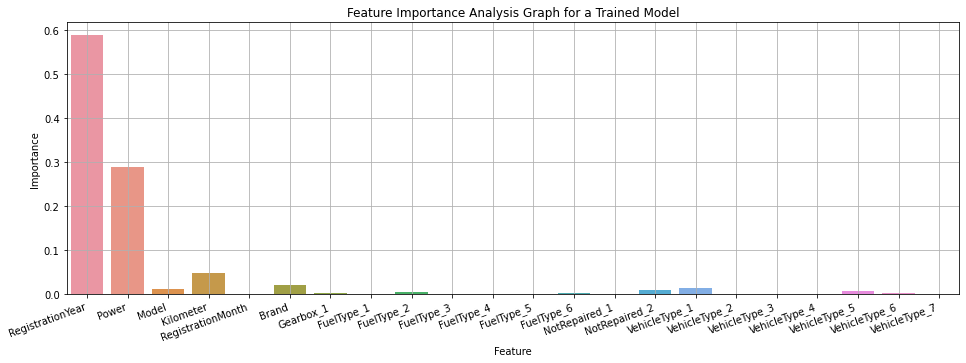

Wall time: 4.43 s


In [35]:
%%time
# Decision Tree Regressor
learn_models(tree, 
             features_data_ohe_train, 
             target_data_ohe_train, 
             features_data_ohe_test, 
             target_data_ohe_test, 
             data_type = 'data_ohe')

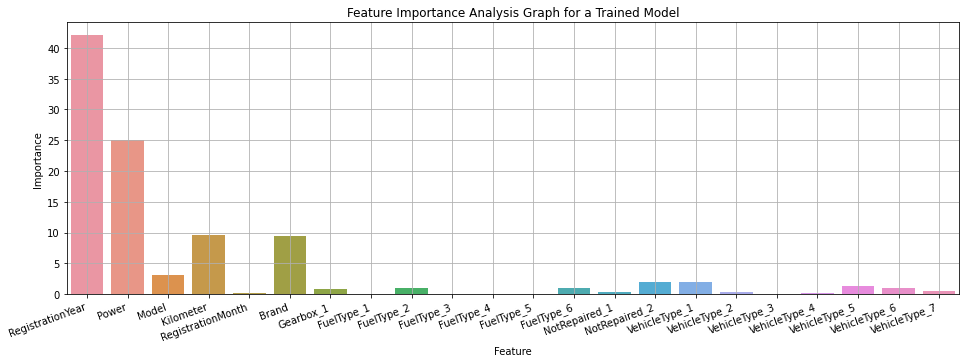

Wall time: 12.3 s


In [36]:
%%time
# CatBoostRegressor
learn_models(cat,  
             features_data_ohe_train, 
             target_data_ohe_train, 
             features_data_ohe_test, 
             target_data_ohe_test, 
             data_type = 'data_ohe',
             regr_name='CatBoostRegressor')

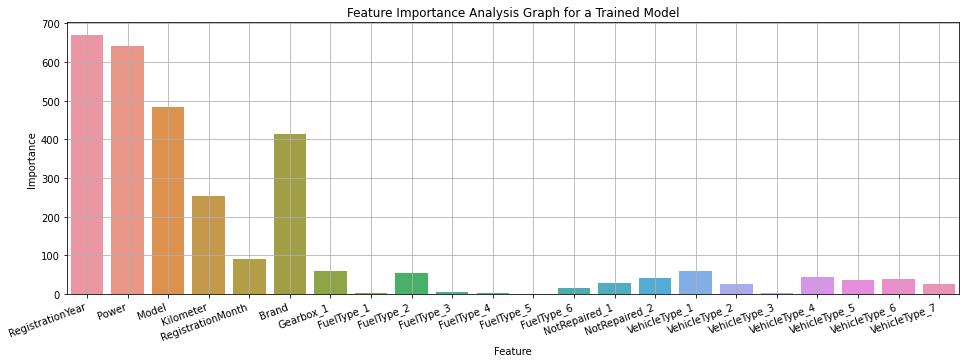

Wall time: 7.85 s


In [37]:
%%time
# Light Gradient Boosting Model Regressor
learn_models([lgbr], 
             features_data_ohe_train, 
             target_data_ohe_train, 
             features_data_ohe_test, 
             target_data_ohe_test, 
             data_type = 'data_ohe', 
             params=lgb_params, 
             regr_name='LGBMRegressor', 
             n_jobs=1)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

### Ordinar encoding for data with preprocessed gaps
    
We train on data with preprocessed gaps, encoded by the method ordinar encoding 
    
</div>

In [38]:
%%time
# Linear Regressions
learn_models(line, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test, 
             data_type = 'data_ord')

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

Wall time: 1.32 s


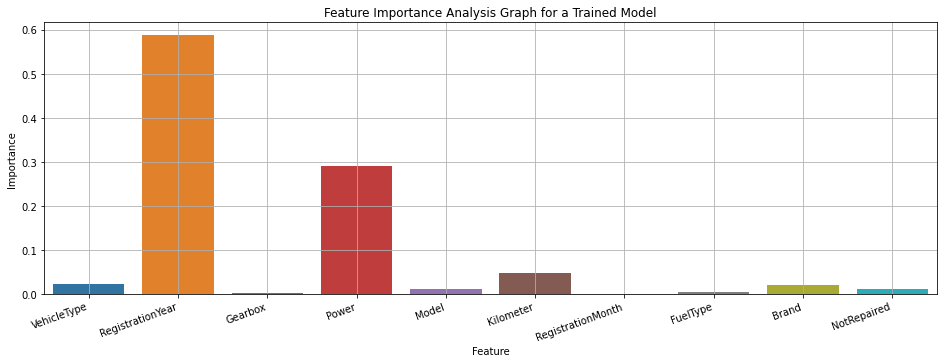

Wall time: 3.08 s


In [39]:
%%time
# Decision Tree Regressor
learn_models(tree, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test, 
             data_type = 'data_ord')

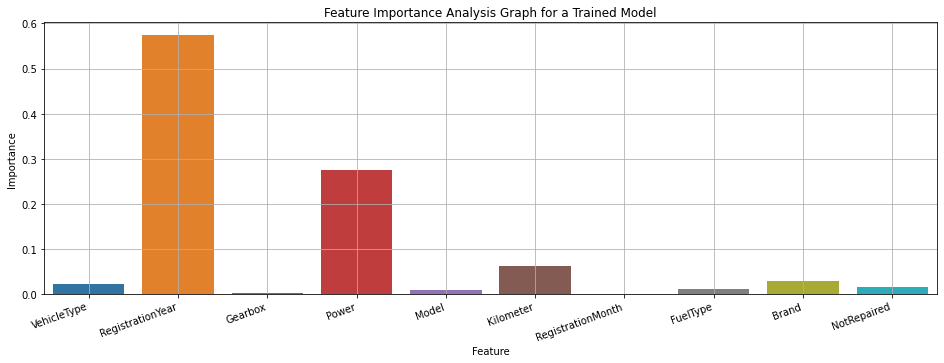

Wall time: 1min 31s


In [40]:
%%time
# Gradient Boosting Regressor
learn_models(gb, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test, 
             data_type = 'data_ord', 
             regr_name='GradientBoostingRegressor')

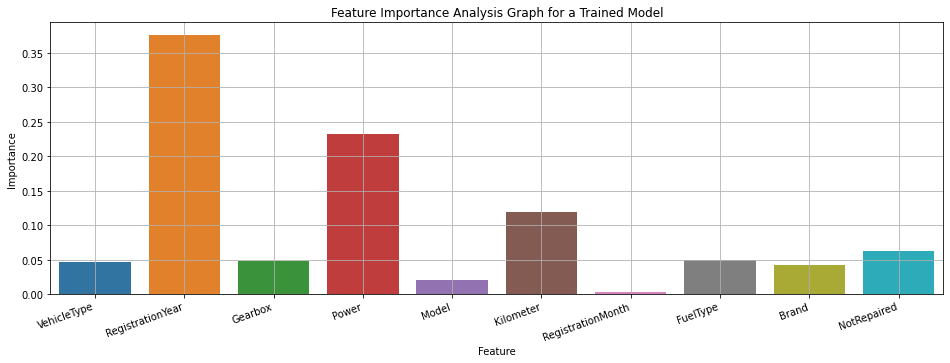

Wall time: 27.8 s


In [41]:
%%time
# eXtreme Gradient Boosting Regressor
learn_models(xgbr, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test, 
             data_type = 'data_ord',
             regr_name='XGBRegressor')

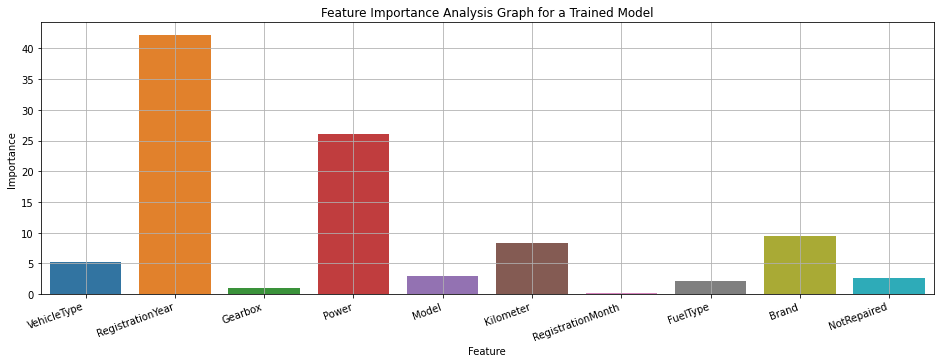

Wall time: 12.1 s


In [42]:
%%time
# CatBoostRegressor
learn_models(cat, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test, 
             data_type = 'data_ord',
             regr_name='CatBoostRegressor')

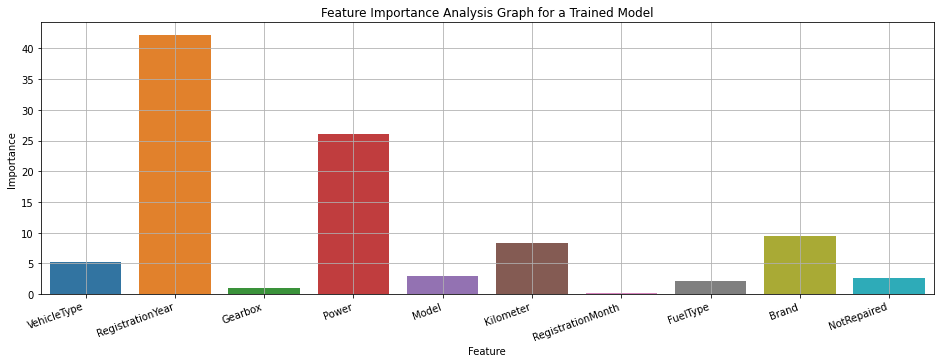

Wall time: 18 s


In [43]:
%%time
# CatBoostRegressor with lgb_params
learn_models(cat, 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test,
             data_type = 'data_ord lgb_params', 
             params=lgb_params,
             model='catboost',
             regr_name='CatBoostRegressor')

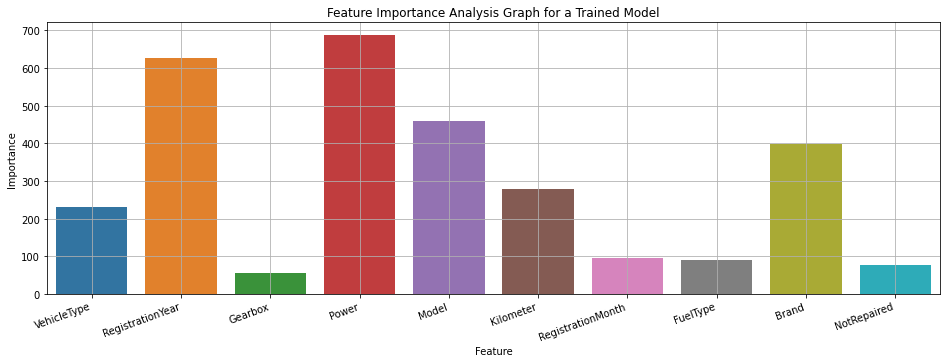

Wall time: 6.63 s


In [44]:
%%time
# Light Gradient Boosting Model Regressor
learn_models([lgbr], 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test,
             data_type = 'data_ord' ,
             params=lgb_params, 
             regr_name='LGBMRegressor', 
             n_jobs=1)

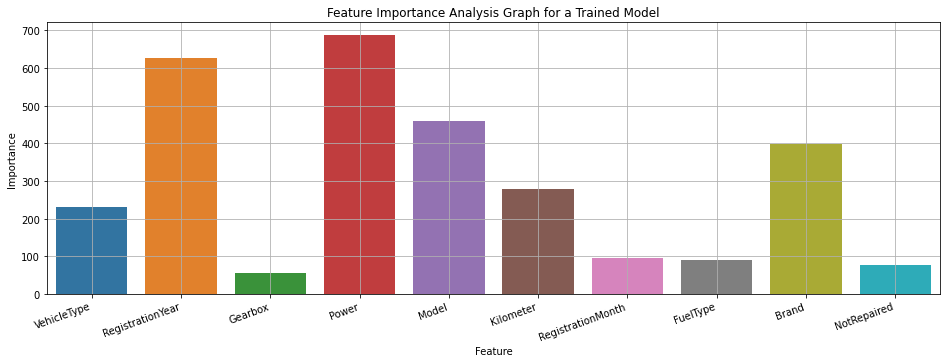

Wall time: 6.67 s


In [45]:
%%time 
# Light Gradient Boosting Model Regressor with lgb_params
learn_models([lgbr], 
             features_data_ord_train, 
             target_data_ord_train, 
             features_data_ord_test, 
             target_data_ord_test,
             data_type = 'data_ord lgb_params', 
             params=lgb_params, 
             model='lgb', 
             regr_name='LGBMRegressor', 
             n_jobs=1)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### One-hot encoding for data with removed gaps
    
    
We train on data with removed gaps, encoded by the method one-hot-encoding 
    
</div>

In [46]:
%%time
# Linear Regressions
learn_models(line, 
             features_df_ohe_train, 
             target_df_ohe_train, 
             features_df_ohe_test, 
             target_df_ohe_test, 
             data_type = 'df_ohe')

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

Wall time: 2.84 s


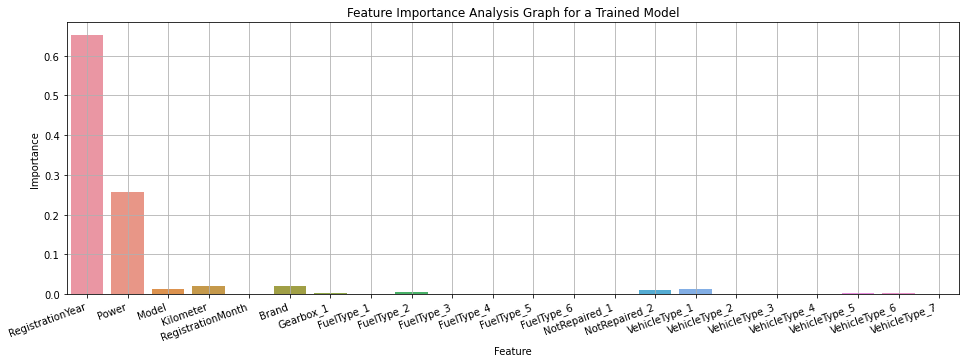

Wall time: 3.98 s


In [47]:
%%time
# Decision Tree Regressor
learn_models(tree, 
             features_df_ohe_train, 
             target_df_ohe_train, 
             features_df_ohe_test, 
             target_df_ohe_test, 
             data_type = 'df_ohe')

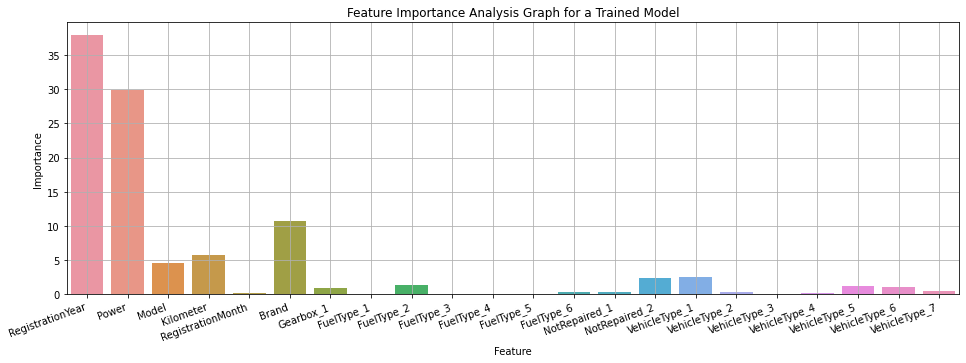

Wall time: 10.9 s


In [48]:
%%time
# CatBoostRegressor
learn_models(cat, 
             features_df_ohe_train, 
             target_df_ohe_train, 
             features_df_ohe_test, 
             target_df_ohe_test, 
             data_type = 'df_ohe',
             regr_name='CatBoostRegressor')

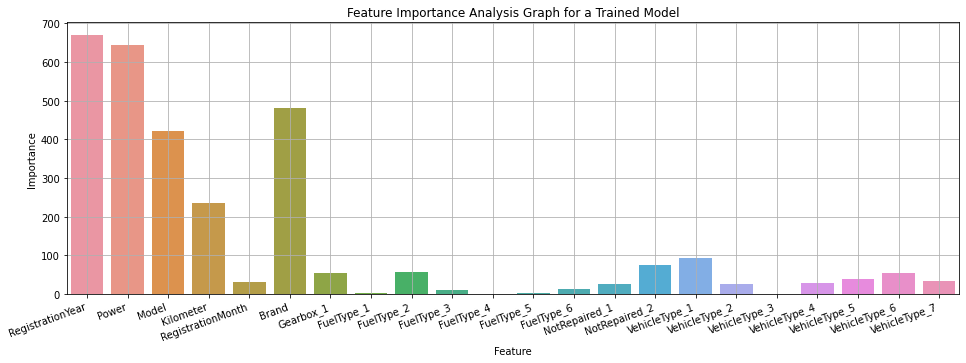

Wall time: 5.15 s


In [49]:
%%time
# Лёгкий градиентный бустинг Датасет ohe с удалёнными пропусками
learn_models([lgbr], 
             features_df_ohe_train, 
             target_df_ohe_train, 
             features_df_ohe_test, 
             target_df_ohe_test, 
             data_type = 'df_ohe', 
             regr_name='LGBMRegressor', 
             n_jobs=1)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
    
### Ordinar encoding for data with removed gaps
    
    
We train on data with removed gaps, encoded by the method ordinar encoding
    
</div>

In [50]:
%%time
# Linear Regressions
learn_models(line, 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test, 
             data_type = 'df_ord')

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

Wall time: 1.14 s


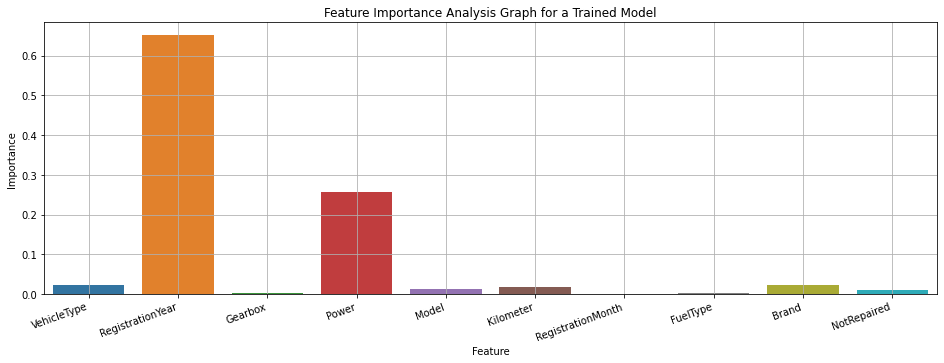

Wall time: 2.61 s


In [51]:
%%time
# Decision Tree Regressor
learn_models(tree, 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test, 
             data_type = 'df_ord')

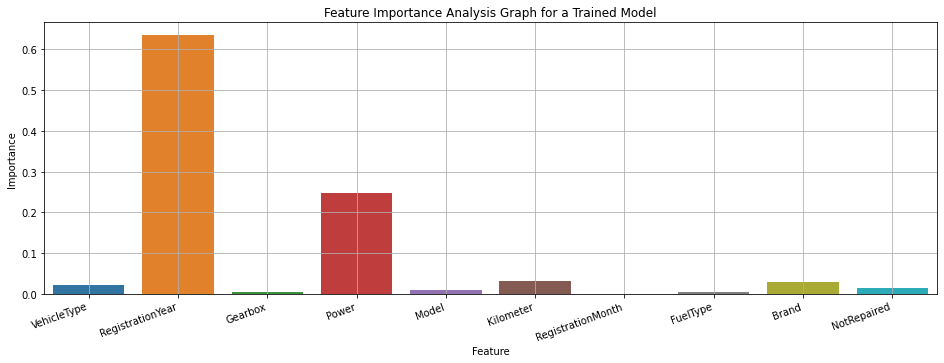

Wall time: 1min 17s


In [52]:
%%time
# Gradient Boosting Regressor
learn_models(gb, 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord', 
             regr_name='GradientBoostingRegressor')

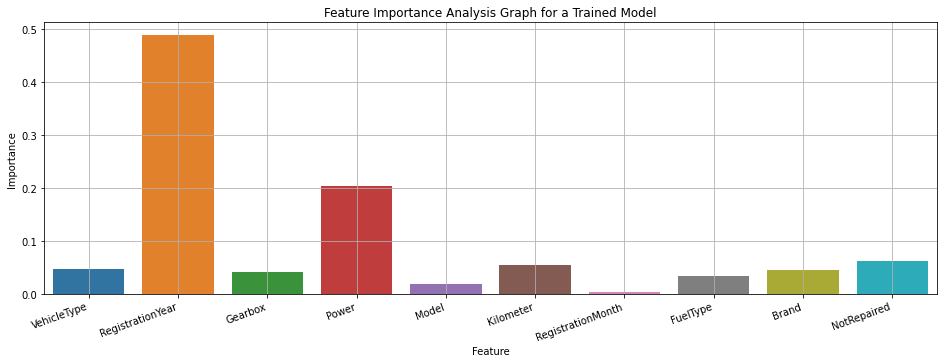

Wall time: 24.5 s


In [53]:
%%time
# eXtreme Gradient Boosting Regressor
learn_models(xgbr, 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord', 
             regr_name='XGBRegressor')

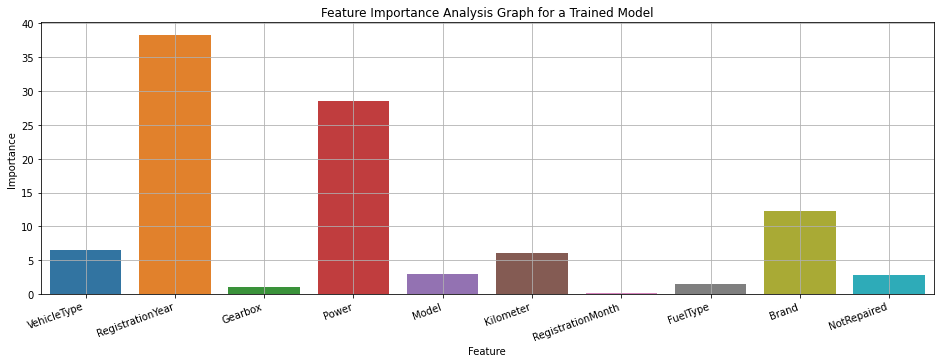

Wall time: 10.5 s


In [54]:
%%time
# CatBoostRegressor
learn_models(cat,  
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord',
             regr_name='CatBoostRegressor')

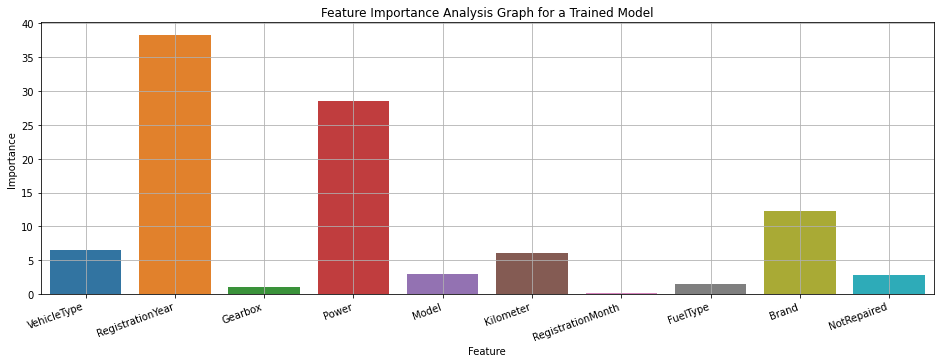

Wall time: 15.7 s


In [55]:
%%time
# CatBoostRegressor with lgb_params

learn_models(cat, 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord lgb_params', 
             params=lgb_params,
             model='catboost',
             regr_name='CatBoostRegressor')

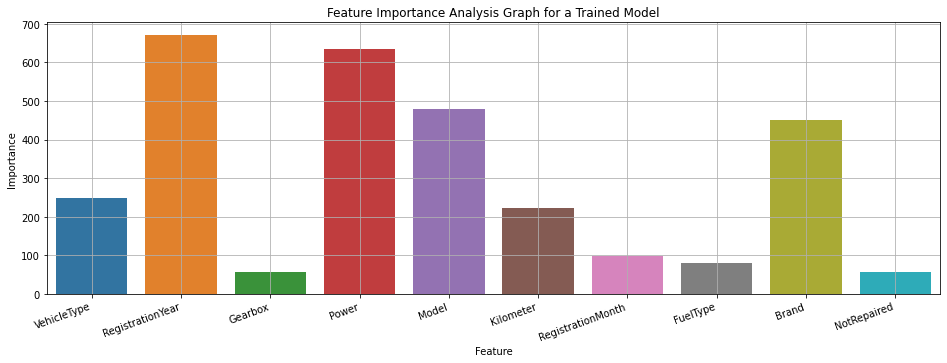

Wall time: 5.98 s


In [56]:
%%time
# Light Gradient Boosting Model Regressor
learn_models([lgbr], 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord', 
             params=lgb_params, 
             regr_name='LGBMRegressor', 
             n_jobs=1)

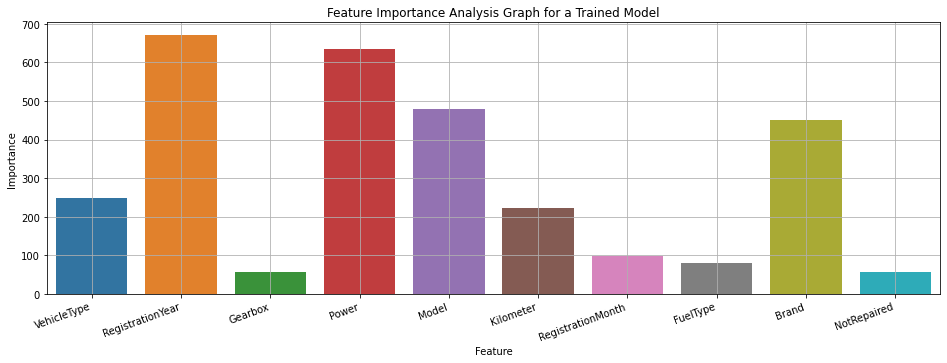

Wall time: 5.92 s


In [57]:
%%time
# Light Gradient Boosting Model Regressor with lgb_params
learn_models([lgbr], 
             features_df_ord_train, 
             target_df_ord_train, 
             features_df_ord_test, 
             target_df_ord_test,
             data_type = 'df_ord lgb_params', 
             params=lgb_params, 
             model='lgb', 
             regr_name='LGBMRegressor', 
             n_jobs=1)

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
Constant Model Prediction    
</div>

In [58]:
predictions_const = pd.Series(target_df_ord_test.mean(), index=target_df_ord_test.index)
rmse_fict = rmse(predictions_const, target_df_ord_test)
print(f'RMSE of Constant Model: {rmse_fict}')

RMSE of Constant Model: 4619.506328341248


In [59]:
results.sort_values(by = 'RMSE test', ascending = True)

,Type of processing,Model,Cross-validation RMSE,RMSE train,RMSE test,Train time,Prediction time
31,df_ord lgb_params,LGBMRegressor,-2598384.02,1526.63,1582.25,0.90,0.12
30,df_ord,LGBMRegressor,-2598384.02,1526.63,1582.25,1.03,0.12
5,data_ohe,LGBMRegressor,-2639578.86,1547.03,1623.28,1.26,0.15
27,df_ord,XGBRegressor,-2734636.49,1591.59,1625.56,6.17,0.07
21,df_ohe,LGBMRegressor,-2734729.30,1620.27,1625.73,1.25,0.15
14,data_ord,LGBMRegressor,-2650499.13,1553.32,1626.99,1.00,0.13
15,data_ord lgb_params,LGBMRegressor,-2650499.13,1553.32,1626.99,1.01,0.13
20,df_ohe,CatBoostRegressor,-2760306.05,1626.99,1635.38,2.89,0.02
29,df_ord lgb_params,CatBoostRegressor,-2775665.20,1631.57,1636.63,2.70,0.01
28,df_ord,CatBoostRegressor,-2775665.20,1631.57,1636.63,2.60,0.02


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
All models predict the result better than the constant one; they can all be used for predictions. It is necessary to choose the optimal business model. To do this, we analyze the data.
</div>

## Model Analysis

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
As a result of training various models on data with multiple types of preprocessing, we need to determine the optimal model for the business. The main parameters that need to be minimized for business are prediction quality, training time, and prediction time. Let's present the results sorted by these parameters.
    
</div>

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
<b>Top 5 models by quality of predictions</b>
    
</div>

In [60]:
results.sort_values(by = 'RMSE test', ascending = True).head(15)

,Type of processing,Model,Cross-validation RMSE,RMSE train,RMSE test,Train time,Prediction time
31,df_ord lgb_params,LGBMRegressor,-2598384.02,1526.63,1582.25,0.90,0.12
30,df_ord,LGBMRegressor,-2598384.02,1526.63,1582.25,1.03,0.12
5,data_ohe,LGBMRegressor,-2639578.86,1547.03,1623.28,1.26,0.15
27,df_ord,XGBRegressor,-2734636.49,1591.59,1625.56,6.17,0.07
21,df_ohe,LGBMRegressor,-2734729.30,1620.27,1625.73,1.25,0.15
14,data_ord,LGBMRegressor,-2650499.13,1553.32,1626.99,1.00,0.13
15,data_ord lgb_params,LGBMRegressor,-2650499.13,1553.32,1626.99,1.01,0.13
20,df_ohe,CatBoostRegressor,-2760306.05,1626.99,1635.38,2.89,0.02
29,df_ord lgb_params,CatBoostRegressor,-2775665.20,1631.57,1636.63,2.70,0.01
28,df_ord,CatBoostRegressor,-2775665.20,1631.57,1636.63,2.60,0.02


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
<b>Top 5 Models by Learning Rate</b>
    
</div>

In [61]:
results.sort_values(by = 'Train time', ascending = True).head(10)

,Type of processing,Model,Cross-validation RMSE,RMSE train,RMSE test,Train time,Prediction time
24,df_ord,LassoLars,-9521129.60,3131.37,3084.71,0.04,0.01
8,data_ord,LassoLars,-9753755.43,3170.13,3187.46,0.05,0.01
22,df_ord,LinearRegression,-8869304.98,2977.87,2932.39,0.07,0.01
6,data_ord,LinearRegression,-9033153.09,3005.11,3022.64,0.08,0.01
23,df_ord,BayesianRidge,-8869304.39,2977.87,2932.39,0.09,0.00
18,df_ohe,LassoLars,-9334793.25,3116.93,3070.26,0.09,0.01
2,data_ohe,LassoLars,-9669984.32,3177.14,3193.62,0.11,0.01
7,data_ord,BayesianRidge,-9033152.81,3005.11,3022.64,0.11,0.01
16,df_ohe,LinearRegression,-8415869.53,2900.53,2862.68,0.16,0.01
0,data_ohe,LinearRegression,-8616429.44,2934.61,2951.23,0.17,0.01


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
<b>Top 5 Models by Prediction Rate</b>
    
</div>

In [62]:
results.sort_values(by = 'Prediction time', ascending = True).head()

,Type of processing,Model,Cross-validation RMSE,RMSE train,RMSE test,Train time,Prediction time
23,df_ord,BayesianRidge,-8869304.39,2977.87,2932.39,0.09,0.00
0,data_ohe,LinearRegression,-8616429.44,2934.61,2951.23,0.17,0.01
1,data_ohe,BayesianRidge,-8616300.75,2934.61,2951.24,0.30,0.01
2,data_ohe,LassoLars,-9669984.32,3177.14,3193.62,0.11,0.01
22,df_ord,LinearRegression,-8869304.98,2977.87,2932.39,0.07,0.01


<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">


Let's show on the charts the best qualities for each model:
Let's consider what type of data preprocessing and encoding was optimal for our models. Let's look at the same parameters
    
    
</div>

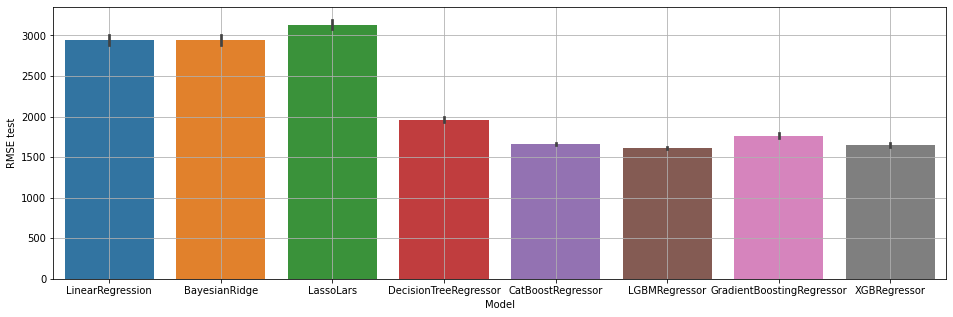

In [63]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=results['Model'], y=results['RMSE test'])
ax.grid(True)
plt.show()

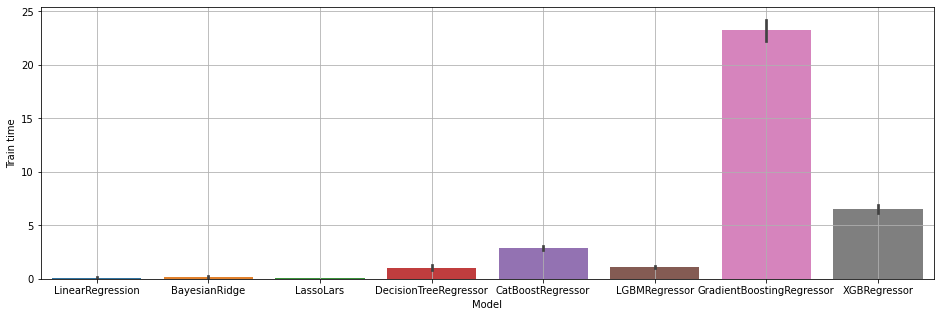

In [64]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=results['Model'], y=results['Train time'])
ax.grid(True)
plt.show()

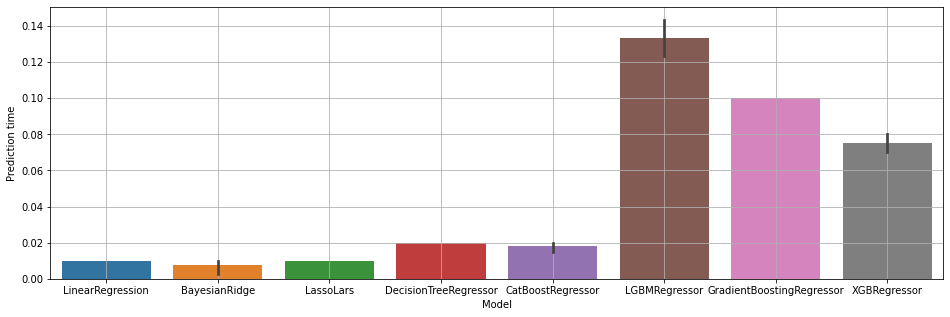

In [65]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=results['Model'], y=results['Prediction time'])
ax.grid(True)
plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
Based on the data obtained: Better 3 models for each of the required qualities:

Prediction quality:
    
- LGBMRegressor (rmse = 1600)
- CatBoostRegressor (rmse = 1650)
- Gradient Boosting Regressor (rmse = 1750)
    
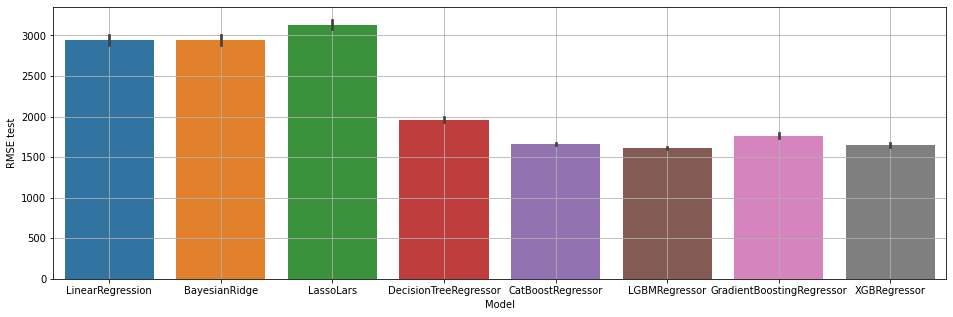
    
Train time:
    
- Linear Regression  (rmse ~ 3000)
- DecisionTreeRegressor (rmse = 2000)
    
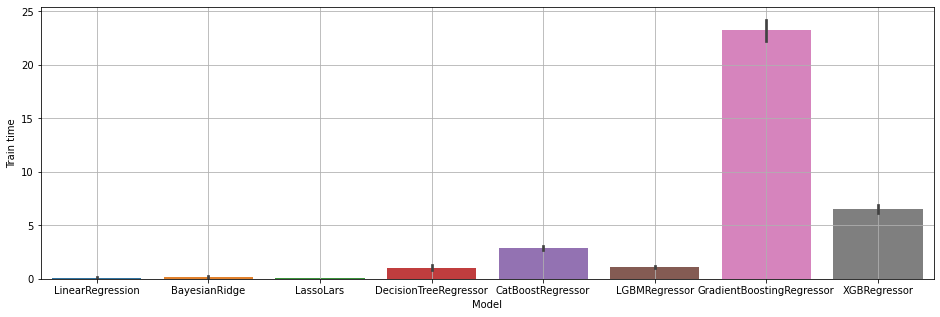
    
Prediction time:
    
- CatBoostRegressor (rmse = 1660)
- Linear Regression (rmse ~ 3000)
    
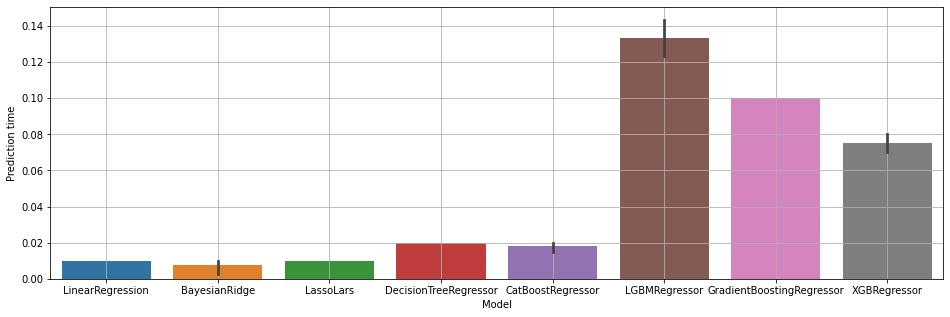
    
The optimal model for all three features: LGBMRegressor. It has a training time of 2 seconds and a prediction of less than 1 second, sometimes faster than loading a browser window on some simple sites. And the learning rate is many times higher than other gradient boosting.
    
If we are trying to improve predictions regardless of training time: choose LGBMRegressor
    
If time is the main criterion, then you need to choose DecisionTreeRegressor. Its rmse is almost two times lower than linear models, with relatively the same prediction time. And the training time is indistinguishable from the human eye.
    
It is also worth noting that the model starts to predict much better with a considerable increase in iterations for CatBoostRegressor or the number of trees for other models. But simultaneously, it increases the training time by several times.

    
<hr>
    
Let's consider what data preprocessing and encoding was optimal for our models. Let's look at the same parameters.
    
</div>

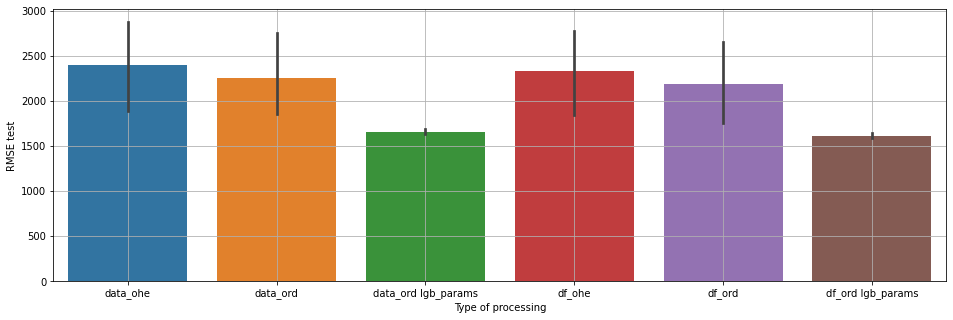

In [66]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=results['Type of processing'], y=results['RMSE test'])
ax.grid(True)
plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">
As a result, the best option for data preprocessing is the minimum preprocessing of gaps and the removal of rows in which the values are difficult to recover. This preprocessing option reduces the time for training the model, as we save 1.5 minutes for preprocessing without losing the quality of the prediction.
    
    
    
<hr>

Let's see how the prediction quality changes if we increase n_estimators for LightGBM for data that received the best RMSE at the previous training stage.


</div>

In [67]:
# Write the results in an empty table
result = pd.DataFrame({'Type of processing': [],
                        'Model' : [], 
                        'Cross-validation RMSE' : [], 
                        'RMSE train' : [], 
                        'RMSE test' : [], 
                        'Train time' : [], 
                        'Prediction time' : []})

In [68]:
%%time
# Light Gradient Boosting Model Regressor for One-hot encoding data with removed gaps
for i in range(100,1201, 100):
    lgbr = lgb.LGBMRegressor(n_estimators=i, objective='root_mean_squared_error')
    learn_models([lgbr], 
                 features_df_ord_train, 
                 target_df_ord_train, 
                 features_df_ord_test, 
                 target_df_ord_test,
                 data_type = 'df_ord lgb_params'+str(i), 
                 params=lgb_params, 
                 model='lgb', 
                 regr_name='LGBMRegressor', 
                 n_jobs=1,
                do_plot = False,
                result_table = 'result')

Wall time: 5min


In [70]:
result.sort_values(by = 'RMSE test', ascending = True)

,Type of processing,Model,Cross-validation RMSE,RMSE train,RMSE test,Train time,Prediction time
11,df_ord lgb_params1200,LGBMRegressor,-2399990.25,1323.07,1510.24,5.25,1.43
10,df_ord lgb_params1100,LGBMRegressor,-2402059.34,1334.88,1511.03,4.66,1.28
9,df_ord lgb_params1000,LGBMRegressor,-2405804.80,1348.42,1513.18,4.18,1.00
8,df_ord lgb_params900,LGBMRegressor,-2411763.95,1362.09,1516.55,5.53,0.94
7,df_ord lgb_params800,LGBMRegressor,-2419126.18,1376.64,1519.34,3.44,0.82
6,df_ord lgb_params700,LGBMRegressor,-2428313.70,1393.32,1523.77,3.56,0.72
5,df_ord lgb_params600,LGBMRegressor,-2438086.02,1412.27,1528.57,2.95,0.64
3,df_ord lgb_params400,LGBMRegressor,-2461141.69,1354.94,1529.22,1.77,0.39
2,df_ord lgb_params300,LGBMRegressor,-2476615.66,1393.91,1534.09,1.38,0.28
4,df_ord lgb_params500,LGBMRegressor,-2453605.83,1433.76,1534.43,2.26,0.52


## Conclusion
<hr>
<div style="border-radius: 15px; box-shadow: 2px 2px 2px; border: 1px solid green; padding: 20px">

As a result of the work performed on the selection of the optimal model for predicting the market value of the car, the following was concluded:
1. To speed up the training time, it is necessary to carry out minimal data preprocessing with the removal of rows in which gaps were noticed that are difficult to recover
2. Categorical features in the data are best encoded using ordinal encoding
3. The best model for prediction accuracy is LGBMRegressor(). Given that the predictions of this regressor are affected by more features, then with their qualitative increase, the model will be less and less wrong each time. Also, for greater accuracy, you can further fine-tune the model's hyperparameters. The average prediction error is 1500 euros, insensibly for the 0-20000 euros range.

4. Signs that most affect the quality of predictions: Year of registration and power of the car.
5. Signs that also significantly affect the quality of predictions: Distance traveled, Brand, and Model of the car.
6. All models were better than constant, so they can all be used.
- For best results: Gradient boosting models
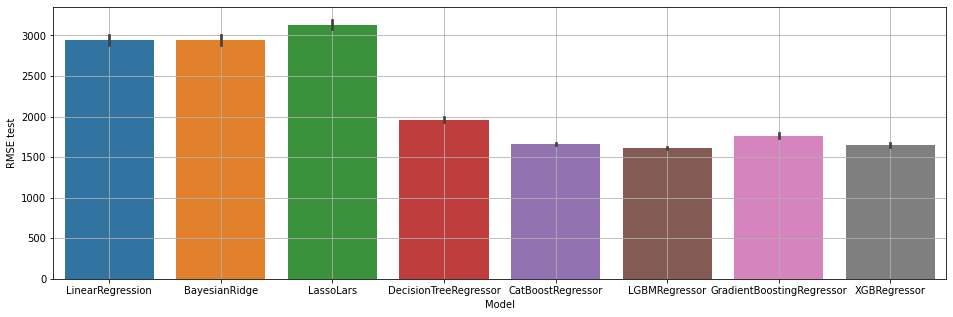
- For fast learning: Linear regressions
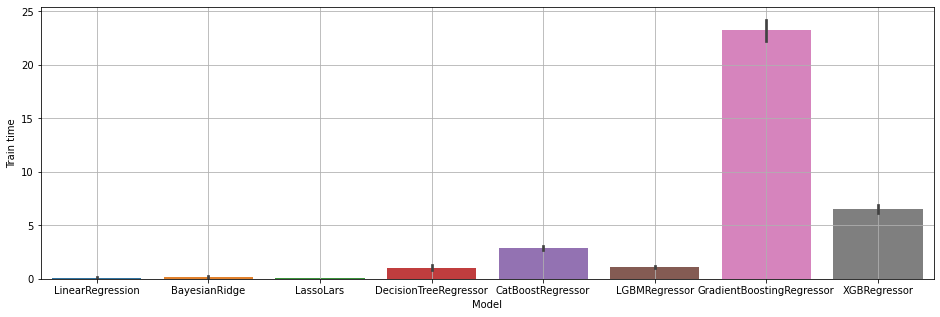
- For fast prediction: Any model containing up to 100 decision trees in hyperparameters. They all give predictions in less than a second.
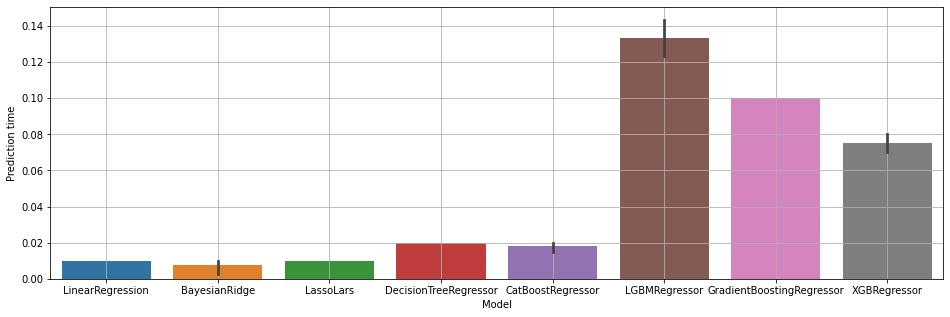
    
    


<hr>

Recommendations
1. Improve data collection:
- When filling in the data on the resource, make it mandatory to fill in the features that significantly affect the quality of the model prediction.
- Set restrictions on the fields in which numerical values are entered. Limit them to the existing maximum engine power; the current year sets the car's registration date.
- Create dropdown lists to select make, brand, fuel type, and engine.
2. Create an index binding to a city/region to collect local statistics on trends in the markup on cars.
2. Add more parameters to the data related to the year of registration and engine power.
2. Add a "Rare" or "Collector's" field so that the model can better predict the price of expensive cars after training.
2. Add the "Without engine" and "With spare parts" fields to clarify why the car could have a low price or the engine power is zero. Otherwise, prevent users from setting zero prices or engine power.


</div>